# Mod 4 Code Challenge: Product Reviews

This assessment is designed to test your understanding of these areas:

1. Data Engineering
    - Understanding an existing ETL pipeline
    - Feature scaling
2. Deep Learning with Neural Networks
    - Creating a TensorFlow neural network model
    - Fitting the model on training data
    - Hyperparameter tuning
    - Model evaluation on test data
3. Business Understanding and Technical Communication
    - Advising a business on what kind of model architecture to use

**Unlike previous challenges, we have provided you some pre-existing code.**  Your work, markdown and code, should build off of the pre-existing material. 

Make sure that your code is clean and readable, and that each step of your process is documented. For this challenge each step builds upon the step before it. If you are having issues finishing one of the steps completely, move on to the next step to attempt every section.  There will be occasional hints to help you move on to the next step if you get stuck, but attempt to follow the requirements whenever possible. 

### Business Understanding

Northwind Trading Company allows customers to leave reviews, but those reviews do not have customer-facing "star ratings".  Instead, customers are free to write text, and other customers can vote on whether the review was helpful.  They find that this is a good trade-off between helping customers make informed decisions about products, and avoiding having any products go unsold because of poor ratings.

Internally, Northwind is interested to know which of these reviews are positive, and which are negative.  **A previous employee of the company has already built a Random Forest Classifier model to perform this classification task.**

Northwind management has heard great things about using Artificial Intelligence for this kind of task, especially Neural Networks like TensorFlow.  **You have been instructed to build a TensorFlow model and advise the company on whether they should switch from the Random Forest Classifier to the TensorFlow model.**

In either case, you want a **classification model** that optimizes for **accuracy**.

### Data Understanding

The data has already been described, imported, and preprocessed in this notebook.

****Below is the work of a previous employee. Take a brief moment to review their work and then complete the tasks at the bottom of the notebook.****

# Product Review Classification

## Business Understanding
Our company wants a tool that will automatically classify product reviews as _positive_ or _negative_ reviews, based on the features of the review.  This will help our Product team to perform more sophisticated analyses in the future to help ensure customer satisfaction.

## Data Understanding
We have a labeled collection of 20,000 product reviews, with an equal split of positive and negative reviews. The dataset contains the following features:

 - `ProductId` Unique identifier for the product
 - `UserId` Unqiue identifier for the user
 - `ProfileName` Profile name of the user
 - `HelpfulnessNumerator` Number of users who found the review helpful
 - `HelpfulnessDenominator` Number of users who indicated whether they found the review helpful or not
 - `Time` Timestamp for the review
 - `Summary` Brief summary of the review
 - `Text` Text of the review
 - `PositiveReview` 1 if this was labeled as a positive review, 0 if it was labeled as a negative review

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("reviews.csv")
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,PositiveReview
0,B002QWHJOU,A37565LZHTG1VH,C. Maltese,1,1,1305331200,Awesome!,This is a great product. My 2 year old Golden ...,1
1,B000ESLJ6C,AMUAWXDJHE4D2,angieseashore,1,1,1320710400,Was there a recipe change?,I have been drinking Pero ever since I was a l...,0
2,B004IJJQK4,AMHHNAFJ9L958,A M,0,1,1321747200,These taste so bland.,"Look, each pack contains two servings of 120 c...",0


The data has already been cleaned, so there are no missing values

In [3]:
df.isna().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Time                      0
Summary                   0
Text                      0
PositiveReview            0
dtype: int64

`PositiveReview` is the target, and all other columns are features

In [4]:
X = df.drop("PositiveReview", axis=1)
y = df["PositiveReview"]

## Data Preparation

First, split into train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(15000, 8)

Second, prepare for modeling. The following `Pipeline` prepares all data for modeling.  It one-hot encodes the `ProductId`, applies a tf-idf vectorizer to the `Summary` and `Text`, keeps the numeric columns as-is, and drops all other columns.

The following code may take up to 1 minute to run.

In [6]:
def drop_irrelevant_columns(X):
    return X.drop(["UserId", "ProfileName"], axis=1)

pipeline = Pipeline(steps=[
    ("drop_columns", FunctionTransformer(drop_irrelevant_columns,
                                        validate=False)),
    ("transform_text_columns", ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), ["ProductId"]),
        ("summary-tf-idf", TfidfVectorizer(max_features=1000), "Summary"),
        ("text-tf-idf", TfidfVectorizer(max_features=1000), "Text")
    ], remainder="passthrough"))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

X_train_transformed.shape

(15000, 11275)

In [7]:
pd.DataFrame(X_train_transformed).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,11235,11236,11237,11238,11239,11240,11241,11242,11243,11244,11245,11246,11247,11248,11249,11250,11251,11252,11253,11254,11255,11256,11257,11258,11259,11260,11261,11262,11263,11264,11265,11266,11267,11268,11269,11270,11271,11272,11273,11274
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,1.500000e+04
mean,0.000067,0.000200,0.000267,0.000267,0.000333,0.000333,0.000067,0.000133,0.000600,0.000333,0.000333,0.000133,0.000133,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.000133,0.000067,0.000467,0.000067,0.000333,0.000067,0.000067,0.000067,0.000200,0.000333,0.000067,0.000133,0.000067,0.000067,0.000333,0.000067,0.000200,0.000067,0.000067,0.000067,0.000067,...,0.011004,0.005522,0.003421,0.008198,0.006175,0.005403,0.002440,0.019506,0.004134,0.032874,0.002112,0.006229,0.004862,0.005405,0.005429,0.001500,0.002757,0.001875,0.002223,0.003910,0.005442,0.018968,0.003125,0.001757,0.003608,0.002715,0.004909,0.007083,0.001233,0.002013,0.003330,0.037335,0.014392,0.001970,0.001686,0.002440,0.001540,2.164467,3.281067,1.299116e+09
std,0.008165,0.014141,0.016328,0.016328,0.018255,0.018255,0.008165,0.011547,0.024488,0.018255,0.018255,0.011547,0.011547,0.008165,0.008165,0.008165,0.008165,0.008165,0.008165,0.011547,0.008165,0.021598,0.008165,0.018255,0.008165,0.008165,0.008165,0.014141,0.018255,0.008165,0.011547,0.008165,0.008165,0.018255,0.008165,0.014141,0.008165,0.008165,0.008165,0.008165,...,0.035838,0.027876,0.029630,0.034006,0.031810,0.029713,0.023626,0.046646,0.028120,0.050122,0.020066,0.030872,0.028998,0.032845,0.031321,0.017807,0.024452,0.019869,0.020717,0.028609,0.031331,0.046333,0.024009,0.020522,0.025710,0.021529,0.029053,0.031997,0.016785,0.018368,0.025642,0.068356,0.044589,0.019136,0.023057,0.025178,0.019416,6.776367,8.285617,4.603391e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.046045e+09
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0

## Modeling

Fit a `RandomForestClassifier` with the best hyperparameters.  The following code may take up to 1 minute to run.

In [8]:
rfc = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=30,
    min_samples_split=15,
    min_samples_leaf=1
)
rfc.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Model Evaluation

We are using _accuracy_ as our metric, which is the default metric in Scikit-Learn, so it is possible to just use the built-in `.score` method

In [9]:
print("Train accuracy:", rfc.score(X_train_transformed, y_train))
print("Test accuracy:", rfc.score(X_test_transformed, y_test))

Train accuracy: 0.9826666666666667
Test accuracy: 0.913


In [10]:
print("Train confusion matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_transformed)))
print("Test confusion matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_transformed)))

Train confusion matrix:
[[7312  177]
 [  83 7428]]
Test confusion matrix:
[[2293  218]
 [ 217 2272]]


## Business Interpretation

The tuned Random Forest Classifier model appears to be somewhat overfit on the training data, but nevertheless achieves 91% accuracy on the test data.  Of the 9% of mislabeled comments, about half are false positives and half are false negatives.

Because this is a balanced dataset, 91% accuracy is a substantial improvement over a 50% baseline.  This model is ready for production use for decision support.

## Please add you work below.
> Rubric items have been provided as guidance. 

### 1) Data Preparation

A train-test split has already been performed.

Additionally, there is already a pipeline in place that drops some columns and converts all text columns into a numeric format for modeling.

**Your only additional data preparation task is feature scaling.**  Tree-based models like Random Forest Classifiers do not require scaling, but TensorFlow neural networks do.

There are two main strategies you can take for this task:

#### Scaling within the existing pipeline

If you are comfortable with pipelines, this is the more polished/professional route.

1. Make a new pipeline, with a `StandardScaler` as the final step.  You can nest the steps of the previous pipeline inside of this new pipeline
2. Generate a new `X_train_transformed_scaled` by calling `.fit_transform` on the new pipeline
3. Generate a new `X_test_transformed_scaled` by calling `.transform` on the new pipeline

#### Scaling after the pipeline has finished

This is a better strategy if you are not as comfortable with pipelines.

1. Instantiate a `StandardScaler` object
2. Generate a new `X_train_transformed_scaled` by calling `.fit_transform` on the scaler object, after you have called `.fit_transform` on the pipeline
3. Generate a new `X_test_transformed_scaled` by calling `.transform` on the scaler object, after you have called `.transform` on the pipeline

If you are getting stuck at this step, skip it.  The model will still be able to fit, although the performance will be worse.  Keep in mind whether or not you scaled the data in your final analysis.

# Feature Scaling

In [11]:
from sklearn.preprocessing import StandardScaler


# create a new pipeline with StandardScaler at the end.  Since all features will be numeric after
# the first transformations, and scaling doesn't hurt one-hot-encoding, we will scale all features.

newpipe = Pipeline(steps=[
    ("drop_columns", FunctionTransformer(drop_irrelevant_columns,
                                        validate=False)),
    ("transform_text_columns", ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), ["ProductId"]),
        ("summary-tf-idf", TfidfVectorizer(max_features=1000), "Summary"),
        ("text-tf-idf", TfidfVectorizer(max_features=1000), "Text"),
    ], remainder="passthrough")),
    ('standard-scaler',StandardScaler())])


X_train_transformed_ss = newpipe.fit_transform(X_train)
X_test_transformed_ss = newpipe.transform(X_test)

X_train_transformed_ss.shape

(15000, 11275)

### 2) Modeling

Build a neural network classifier.  Specifically, use the `keras` submodule of the `tensorflow` library to build a multi-layer perceptron model with the `Sequential` interface.

See the [`tf.keras` documentation](https://www.tensorflow.org/guide/keras/overview) for an overview on the use of `Sequential` models. See the [Keras layers documentation](https://keras.io/layers/core/) for descriptions of the `Dense` layer options.  

1. Instantiate a `Sequential` model
2. Add an input `Dense` layer.  You'll need to specify a `input_shape` = (11275,) because this is the number of features of the transformed dataset.
3. Add 2 `Dense` hidden layers.  They can have any number of units, but keep in mind that more units will require more processing power.  We recommend an initial `units` of 64 for processing power reasons.
4. Add a final `Dense` output layer.  This layer must have exactly 1 unit because we are doing a binary prediction task.
5. Compile the `Sequential` model
6. Fit the `Sequential` model on the preprocessed training data (`X_train_transformed_scaled`) with a b`batch_size` of 50 and `epochs` of 5 for processing power reasons.


In [12]:
def make_model1():
    import tensorflow as tf
    from keras.models import Sequential
    from keras.layers import Dense

    #instantiate a new, basic sequential model with dense layers
    model = Sequential()

    #model has 11275 features, so that will be the input shape.  We will use ReLU activations
    #and add 2 more dense hidden layers
    model.add(Dense(64, input_shape = (11275,), activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))

    #since we have a binary target, 1 output node and a sigmoid activation is appropriate
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [13]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from IPython.display import display 
from sklearn.metrics import confusion_matrix

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

model = KerasClassifier(build_fn = make_model1, epochs = 5, batch_size = 50, verbose = 0)

pipe = Pipeline([('model', model)])

results = cross_val_score(pipe, X_train_transformed_ss, y_train, cv = kfold, scoring = 'accuracy')
print('CV Results:')
display(pd.DataFrame(results))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
CV Results:


,0
0,0.9156
1,0.9080
2,0.9134


### 3) Model Tuning + Feature Engineering

If you are running out of time, skip this step.

Tune the neural network model to improve performance.  This could include steps such as increasing the units, changing the activation functions, or adding regularization.

We recommend using using a `validation_split` of 0.1 to understand model performance without utilizing the test holdout set.

You can also return to the preprocessing phase, and add additional features to the model.

In [14]:
def make_model2():
    import tensorflow as tf
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import Dropout

    #instantiate a new, basic sequential model with dense layers
    model = Sequential()

    #model has 11275 features, so that will be the input shape.  We will use ReLU activations
    #and add 3 more dense hidden layers, and add dropout layers for regularization
    model.add(Dense(64, input_shape = (11275,), activation = 'relu'))
    model.add(Dropout(rate = .2))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(rate = .2))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(rate = .2))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(rate = .2))

    #since we have a binary target, 1 output node and a sigmoid activation is appropriate
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [15]:
model = KerasClassifier(build_fn = make_model2, epochs = 5, batch_size = 50, verbose = 0)

pipe = Pipeline([('model', model)])

results = cross_val_score(pipe, X_train_transformed_ss, y_train, cv = kfold, scoring = 'accuracy')
print('CV Results:')
display(pd.DataFrame(results))

CV Results:


,0
0,0.9204
1,0.9160
2,0.9158


In [16]:
def make_model3():
    import tensorflow as tf
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import Dropout

    #instantiate a new, basic sequential model with dense layers
    model = Sequential()

    #model has 11275 features, so that will be the input shape.  We will use ReLU activations
    #and add 4 more dense hidden layers, increase the neurons per layer, and increase the
    #regularization (which seems to be helping the cross validation scores)
    model.add(Dense(64, input_shape = (11275,), activation = 'relu'))
    model.add(Dropout(rate = .4))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(rate = .5))
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(rate = .5))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(rate = .3))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dropout(rate = .2))

    #since we have a binary target, 1 output node and a sigmoid activation is appropriate
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [17]:
model = KerasClassifier(build_fn = make_model3, epochs = 5, batch_size = 50, verbose = 0)

pipe = Pipeline([('model', model)])

results = cross_val_score(pipe, X_train_transformed_ss, y_train, cv = kfold, scoring = 'accuracy')
print('CV Results:')
display(pd.DataFrame(results))

CV Results:


,0
0,0.9304
1,0.9258
2,0.9192


In [18]:
def make_model4():
    import tensorflow as tf
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import Dropout

    #instantiate a new, basic sequential model with dense layers
    model = Sequential()

    #model has 11275 features, so that will be the input shape.  We will use ReLU activations
    #and add 2 more dense hidden layers, increase neurons again, and keep strong regularization
    model.add(Dense(256, input_shape = (11275,), activation = 'relu'))
    model.add(Dropout(rate = .7))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(rate = .5))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(rate = .5))


    #since we have a binary target, 1 output node and a sigmoid activation is appropriate
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [19]:
model = KerasClassifier(build_fn = make_model4, epochs = 5, batch_size = 50, verbose = 0)

pipe = Pipeline([('model', model)])

results = cross_val_score(pipe, X_train_transformed_ss, y_train, cv = kfold, scoring = 'accuracy')
print('CV Results:')
display(pd.DataFrame(results))

CV Results:


,0
0,0.9316
1,0.9264
2,0.9250


In [20]:
def make_model5():
    import tensorflow as tf
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import Dropout

    #instantiate a new, basic sequential model with dense layers
    model = Sequential()

    #model has 11275 features, so that will be the input shape.  We will use ReLU activations
    #and add 3 more dense hidden layers, increase neurons again, and keep strong regularization
    model.add(Dense(256, input_shape = (11275,), activation = 'relu'))
    model.add(Dropout(rate = .8))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(rate = .5))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(rate = .5))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(rate = .3))

    #since we have a binary target, 1 output node and a sigmoid activation is appropriate
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [21]:
model = KerasClassifier(build_fn = make_model5, epochs = 5, batch_size = 50, verbose = 0)

pipe = Pipeline([('model', model)])

results = cross_val_score(pipe, X_train_transformed_ss, y_train, cv = kfold, scoring = 'accuracy')
print('CV Results:')
display(pd.DataFrame(results))

CV Results:


,0
0,0.9250
1,0.9310
2,0.9218


### 4) Model Evaluation

Choose a final `Sequential` model, add layers, and compile.  Fit the model on the preprocessed training data (`X_train_transformed_scaled`, `y_train`) and evaluate on the preprocessed testing data (`X_test_transformed_scaled`, `y_test`) using `accuracy_score`.

In [22]:
from sklearn.metrics import accuracy_score

pipe.fit(X_train_transformed_ss,y_train)
ypred = pipe.predict(X_test_transformed_ss)
print('Confusion Matrix')
display(pd.DataFrame(confusion_matrix(y_test,ypred)))
print('accuracy score is:')
accuracy_score(y_test,ypred)

Confusion Matrix


,0,1
0,2338,173
1,138,2351


accuracy score is:


0.9378

### 5) Technical Communication

Write a paragraph explaining whether Northwind Trading Company should switch to using your new neural network model, or continue to use the Random Forest Classifier.  Beyond a simple comparison of performance, try to take into consideration additional considerations such as:

 - Computational complexity/resource use
 - Anticipated performance on future datasets (how might the data change over time?)
 - Types of mistakes made by the two kinds of models

You can make guesses or inferences about these considerations.

**Include at least one visualization** comparing the two types of models.  Possible points of comparison could include ROC curves, colorized confusion matrices, or time needed to train.


## Stats for Random Forest Classifier:

RFC Test accuracy: 0.913
RFC Test confusion matrix:


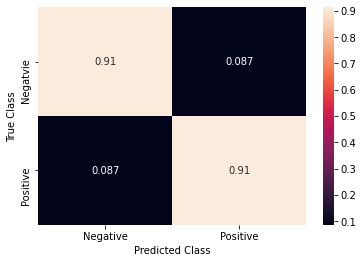

time to retrain, predict, and test for random forest classificer is 28.2722806930542 seconds


In [57]:
import seaborn as sns
import time
import matplotlib.pyplot as plt

#Training and Evaluation
start = time.time()
rfc.fit(X_train_transformed, y_train)
rfcconfusion_matrix = confusion_matrix(y_test, rfc.predict(X_test_transformed),
                                       normalize = 'true')
ypred = rfc.predict(X_test_transformed)
end = time.time()
rfc_time = end - start

#Reporting
print("RFC Test accuracy:", accuracy_score(y_test, ypred))

print("RFC Test confusion matrix:")
sns.heatmap(rfcconfusion_matrix, annot = True, xticklabels = ['Negative','Positive'],
            yticklabels = ['Negatvie','Positive'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

print(f'time to retrain, predict, and test for random forest classificer is {rfc_time} seconds')


## Stats for Deep Learning Neural Network

test Confusion Matrix
test accuracy score is: 0.9396
confusion matrix for neural network is:


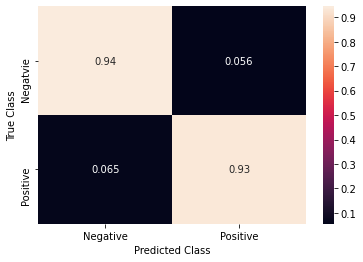

time to retrain, predict, and test for neural netword is 5.0213682651519775 seconds


In [56]:
#Training and evaluation

NNmodel = KerasClassifier(build_fn = make_model4, epochs = 5, batch_size = 50, verbose = 0)
pipe = Pipeline([('model', NNmodel)])

start = time.time()

pipe.fit(X_train_transformed_ss,y_train)
ypred = pipe.predict(X_test_transformed_ss)
NN_confusion_matrix = confusion_matrix(y_test,ypred, normalize = 'true')
accuracy_score(y_test,ypred)

end = time.time()
NNtime = end - start

#Reporting
print('test accuracy score is:', accuracy_score(y_test,ypred))

print('confusion matrix for neural network is:')
sns.heatmap(NN_confusion_matrix, annot = True, xticklabels = ['Negative','Positive'],
            yticklabels = ['Negatvie','Positive'])
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

print(f'time to retrain, predict, and test for neural netword is {NNtime} seconds')

# Results:
### Increase training and predicting speed
When run on a server with access to a GPU, you can see that the neural network we have designed run much faster, in fact 6x faster.  This is because Tensorflow can take advantage of distributed processing to use multiple available processors to complete a task, while the SKlearn random forest library only makes use of one.

### Improved Accuracy
Our deep learning model is 3% more accurate than the random forest classifier, making both fewer false negative and fewer false positive errors.  Only 6% of negative reviews are misclassified as positive and only 7% of positive reviews are misclassified as negative.  In comparision, the random forest classifier misclassifies almost 9% of each.

### Summary:
Our engineered and tuned deep learning neural network model is an improvement on the random forest classifier in training speed, prediction speed, and accuracy across both classes.  It is a superior model.

### Note
The deep learning model is optimal when run on distributed computing architectures.  This includes computers with strong GPUs, but also many cloud available servies such as AWS and Google cloud services.  This model was developed, trained, and benchmarked on Google Colab.